In [1]:
from __future__ import with_statement
from contextlib import contextmanager
import sys
import os

sys.path.append(r"C:\Program Files\PTI\PSSE35\35.2\PSSBIN")
os.environ['PATH'] = (r"C:\Program Files\PTI\PSSE35\35.2\PSSBIN;" + os.environ['PATH'])
sys.path.append(r"C:\Program Files\PTI\PSSE35\35.2\PSSPY38")
os.environ['PATH'] = (r"C:\Program Files\PTI\PSSE35\35.2\PSSPY38;" + os.environ['PATH'])
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pssepath
import pandas as pd
import numpy as np
import psse35
pssepath.add_pssepath()
import psspy
import redirect
import dyntools
import pssplot
import random

import seaborn as sns
import matplotlib.pyplot as plt
import glob
from pytictoc import TicToc
import re
import shutil

    Sets PSSE environment to latest minor version among installed versions of PSSE 35.
    Use psse35.set_minor(n) to set PSSE35 minor version (n) to use.
        Example, for PSSE 35.0.x, use this as: psse35.set_minor(0)


In [2]:
@contextmanager
def silence(file_object=None):
    """
    Discard stdout (i.e. write to null device) or
    optionally write to given file-like object.
    """
    if file_object is None:
        file_object = open(os.devnull, 'w')

    old_stdout = sys.stdout
    try:
        sys.stdout = file_object
        yield
    finally:
        sys.stdout = old_stdout


def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)
        
def txtoutdelete(directory):
    for (path, dir, files) in os.walk(directory):
        for filename in files:
            ext = os.path.splitext(filename)[-1]
            #print(ext)
            if ext == '.txt' or ext == '.out':
                try:
                    os.remove(path + '/' + filename)
                except:
                    break
                #print('yes')

def clean_text(text):
    cleaned_text = re.sub('[\{\}\[\]\/?,;:|\)*~`!^\_+<>@\#$%&\\\=\(\'\"\♥\♡\ㅋ\ㅠ\ㅜ\ㄱ\ㅎ\ㄲ\ㅡ]', '', text)
    return cleaned_text

In [3]:
folder = 'C:/Users/smartgrid_AI/Desktop/netzero/case'
savefolder = 'C:/Users/smartgrid_AI/Desktop/netzero/case'
runfolder = 'C:/Users/smartgrid_AI/Documents/kms/netzero'
#name = 'SMIBPLB_final'
name = 'SMIBPLB_TEST'
rawfile = folder+'/'+name+'.raw'
dynfile = folder+'/'+'SMIB34_ori'+'.dyr'

In [4]:
gen_bus_num = 1
poi_bus_num = 2
inf_bus_num = 4

In [5]:
# User-dependent variable
MVAbase = 3
Prated = 3/MVAbase #(3MW)
Anum = 3 # 3, 5, 6, 7, 8, 10, 11, 12
Cnum = 1
timestep = 0.008333

## Initial Icon Values
## Volage Control
POIFLAG = 0 # 0: Voltage control at the bus before transformer / 1: POI voltage ctrl (after transformer)
if POIFLAG == 0:
    BusVC = 0
    Fmonb = 0
    Tmonb = 0
    Bcid = 0
else:
    BusVC = 2
    Fmonb = 2
    Tmonb = 1
    Bcid = 1
    
## REECA ICONs
PFFLAG = 0 # 1: Power factor ctrl / 0: Plant Q ctrl
PFLAG = 0  # 1: With WTDTAU1 / 0: Without WTDTAU1
PQFLAG = 0 # 1: P Priority / 0: Q Priority

## REPCA ICONs
VCFLAG = 1 # 1: Line Drop Compensation / 0: Droop 
REFFLAG = 1 # 1: Voltage ctrl / 0: Q ctrl

In [6]:
def plb_setting(raw_file, dyr_file, p0, OUTDIR, REFFLAG, PFFLAG, tend, Anum, Cnum):
    Pini = Prated*MVAbase*p0
    
    with silence():
        from psspy import _i, _f, _s
        redirect.psse2py()
        psspy.psseinit(500000000)
        psspy.read(0, raw_file)
        psspy.dyre_new([1,1,1,1], dyr_file,"","","")
    with silence():
        ORI_REGCA = np.array([0.02, 10, 0.9, 0.4, 1.22, 1.2, 0.8, 0.4, -1.2, 0.02, 0.7, 1.2, -1.2, 0.7], dtype=np.float32)
        ORI_REECA = np.array([0.9, 1.1, 0.02, 0.05, 0.05, 3, 1, -1, 0, 0, 0, 0, 0.2, 1, -1, 1.1, \
                              0.9, 0, 1, 0, 1, 0, 0, 999, -999, 1, 0, 1.2, 0, 0, 0, 0.49, \
                             0, 0.5, 1, 1.2, 1, 0, 0, 0.49, 0, 0.5, 1, 1.2, 1], dtype=np.float32)
        ORI_REPCA = np.array([0.02, 0, 0.5, 0, 0, 0.7, 0, 0, 0, 0.1, -0.1, 0, 0, 1, -1, 0, 0.5, \
                             0.02, -0.0006, 0.0006, 999, -999, 1, 0, 0.2, 20, 20])
        ORI_WTDTA = np.array([3, 0, 0.5, 60, 1])
        ORI_FRQTPAT = np.array([57, 62, 0.1, 0.08])
        ORI_VTGTPAT = np.array([0.4, 1.3, 0.1, 0.08])
        REECA_Icon = np.array([0, PFFLAG, 0, 0, PFLAG, PQFLAG], dtype=np.int32)
        
        if Anum == 10:
            REPCA_Icon = np.array([BusVC, Fmonb, Tmonb, Bcid, VCFLAG, REFFLAG, 0], dtype=np.int32)
        else:
            REPCA_Icon = np.array([BusVC, Fmonb, Tmonb, Bcid, VCFLAG, REFFLAG, 1], dtype=np.int32)

        
        for i in range(REECA_Icon.shape[0]):
            psspy.change_wnmod_icon(1,r"""1""",r"""REECA1""", i+1, REECA_Icon[i])
        for i in range(REPCA_Icon.shape[0]):
            psspy.change_wnmod_icon(1,r"""1""",r"""REPCA1""", i+1, REPCA_Icon[i])

        for i in range(ORI_REGCA.shape[0]):
                #psspy.change_ldmod_con(41, r"""16""", r"""CMLDBLDGU2""", Par_num[i]+1, X[i])
            psspy.change_wnmod_con(gen_bus_num,r"""1""",r"""REGCA1""",i+1, ORI_REGCA[i])
        for i in range(ORI_REECA.shape[0]):        
            psspy.change_wnmod_con(gen_bus_num,r"""1""",r"""REECA1""",i+1, ORI_REECA[i])
        for i in range(ORI_REPCA.shape[0]):        
            psspy.change_wnmod_con(gen_bus_num,r"""1""",r"""REPCA1""",i+1, ORI_REPCA[i])
        for i in range(ORI_WTDTA.shape[0]):        
            psspy.change_wnmod_con(gen_bus_num,r"""1""",r"""WTDTA1""",i+1, ORI_WTDTA[i])
        for i in range(ORI_FRQTPAT.shape[0]):        
            psspy.change_cctmscomod_con(r"""FRQTPAT""",1, i+1, ORI_FRQTPAT[i])
            psspy.change_cctmscomod_con(r"""VTGTPAT""",2,i+1,ORI_VTGTPAT[i])

        if Anum == 5:
            if (Cnum == 3) | (Cnum == 4):
                psspy.change_wnmod_con(1,r"""1""",r"""REPCA1""",26, 100/3)
                
        psspy.machine_chng_3(1,r"""1""",[_i,_i,_i,_i,_i,_i,_i],[Pini,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f])
        psspy.machine_chng_3(1,r"""1""",[_i,_i,_i,_i,_i,_i,_i],[_f,_f,_f,_f, Pini,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f])
        psspy.machine_chng_3(1,r"""1""",[_i,_i,_i,_i,_i,_i,_i],[_f,_f,_f,_f,_f, -Pini,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f])
        psspy.machine_chng_3(1,r"""1""",[_i,_i,_i,_i,_i,_i,_i],[_f,_f,_f, 0,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f])
        psspy.machine_chng_3(4,r"""1""",[_i,_i,_i,_i,_i,_i,_i],[-Pini,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f])

        # Converging and Converting:
        psspy.fnsl([0,0,0,1,1,0,99,0])
        psspy.fnsl([0,0,0,1,1,0,99,0])
        psspy.cong(0)
        psspy.conl(0,1,1,[0,0],[ 100.0,0.0,0.0, 100.0])
        psspy.conl(0,1,2,[0,0],[ 100.0,0.0,0.0, 100.0])
        psspy.conl(0,1,3,[0,0],[ 100.0,0.0,0.0, 100.0])
        #psspy.fdns([0,0,0,1,1,0,99,0])
        psspy.ordr(0)
        psspy.fact()
        psspy.tysl(0)

        # Change Solution Time Step
        psspy.dynamics_solution_param_2([_i,_i,_i,_i,_i,_i,_i,_i],[_f,_f, timestep,_f,_f,_f,_f,_f])
        #psspy.dynamics_solution_param_2([_i,_i,_i,_i,_i,_i,_i,_i],[_f,_f, 0.00025,_f,_f,_f,_f,_f])

        # Channel Setting
        psspy.chsb(0,1,[-1,-1,-1,1,1,0])
        psspy.chsb(0,1,[-1,-1,-1,1,2,0])
        psspy.chsb(0,1,[-1,-1,-1,1,3,0])
        psspy.chsb(0,1,[-1,-1,-1,1,21,0])
        psspy.chsb(0,1,[-1,-1,-1,1,12,0])
        psspy.chsb(0,1,[-1,-1,-1,1,14,0])
        psspy.chsb(0,1,[-1,-1,-1,1,16,0])
        psspy.machine_array_channel([31,2,1],r"""1""","")
        psspy.machine_array_channel([32,3,1],r"""1""","")
        psspy.state_channel([33,4],"")
        
        #psspy.set_chnfil_type(0)
    
    psspy.strt_2([0,1],OUTDIR)
    psspy.change_wnmod_var(1,r"""1""",r"""REPCA1""",2, 0)
    psspy.change_wnmod_var(1,r"""1""",r"""REECA1""",3, np.arccos(1))
    psspy.change_wnmod_var(1,r"""1""",r"""REPCA1""",4, p0)
    psspy.run(0, tend,0,1,0)
    
def sim_run(OUTDIR, txtfile, t):
    with silence():
        psspy.change_channel_out_file(OUTDIR)
        psspy.run(0,t,0,1,0)
        psspy.change_channel_out_file(OUTDIR)

def sim_out(OUTDIR, txtfile):
    with silence():
        achnf=dyntools.CHNF(str(OUTDIR))
        achnf.txtout()
        shutil.move(runfolder+'/'+txtfile, savefolder+'/'+txtfile)
        #achnf.xlsout(show=False, xlsfile='', outfile='', sheet='Result', overwritesheet=True)
        run = 1
        psspy.progress_output(1)
        psspy.delete_all_plot_channels()
        psspy.dynamicsmode(0)
        ierr_close_line = psspy.close_powerflow()
        ierr_del_tmpfiles = psspy.deltmpfiles()
        
def voltvar(v, qmax, ud):
    if v>1.05:
        qref = -qmax
    elif v>1+ud:
        qref = -qmax*(v-ud-1)/(0.05-ud)
    elif v>1-ud:
        qref = 0
    elif v>0.95:
        qref = qmax*(-v+1-ud)/(0.05-ud)
    else:
        qref = qmax
        
    return qref

In [7]:
def sim_sim(Anum, Cnum):
    from psspy import _i, _f, _s
    redirect.psse2py()
    ## Case Number Selection
    if Anum==3: # P control
        p0 = 1
        REFFLAG = 0
        PFFLAG = 0
    if Anum == 5: # P-F control
        REFFLAG = 0
        PFFLAG = 0
        if Cnum == 1:
            p0 = 1
            d = 0.05
        elif Cnum == 2:
            p0 = 0.5
            d = 0.05
        elif Cnum == 3:
            p0 = 1
            d = 0.03
        else:
            p0 = 0.5
            d = 0.03
    if Anum == 6: # Q control
        REFFLAG = 0
        PFFLAG = 0
        if Cnum == 1:
            p0 = 1
        else:
            p0 = 0.2
    if Anum == 7: # PF control
        PFFLAG = 1
        REFFLAG = 0
        if Cnum == 1:
            p0 = 1
        else:
            p0 = 0.5
    if Anum == 8: # Q-V control
        PFFLAG = 0
        REFFLAG = 0
        if Cnum == 1:
            p0 = 1
        else:
            p0 = 0.5
    if Anum == 10: # FRT
        PFFLAG = 0
        REFFLAG = 0
        if Cnum == 1:
            p0 = 1
        else:
            p0 = 1
            
    if Anum == 11:
        PFFLAG = 0
        REFFLAG = 0
        if Cnum == 1:
            p0 = 1
        else:
            p0 = 0.2
            
    if Anum == 12: # Reactive Current Injection during Faults
        PFFLAG = 0
        REFFLAG = 0
        if Cnum == 1:
            p0 = 1
        else:
            p0 = 0.2
    ## Conduct Simulation
    
    if Anum == 3:
        # S1
        outfile3 = 'a'+ str(Anum) + '.out'
        txtfile3 = 'a'+ str(Anum) + '.txt'
        OUTDIR3 = savefolder + '/' + outfile3
        
        plb_setting(rawfile, dynfile, p0, OUTDIR3, REFFLAG, PFFLAG, 20, Anum, Cnum) # t=20 ~ initialization stage
        psspy.change_wnmod_var(1,r"""1""",r"""REPCA1""",4, 0.8)    # Pref change
        sim_run(OUTDIR3, txtfile3, 50.0)
        psspy.change_wnmod_var(1,r"""1""",r"""REPCA1""",4, 0.5)    # Pref change
        sim_run(OUTDIR3, txtfile3, 80.0)
        psspy.change_wnmod_var(1,r"""1""",r"""REPCA1""",4, 0.2)    # Pref change
        sim_run(OUTDIR3, txtfile3, 110.0)
        sim_out(OUTDIR3, txtfile3)
        
        Idata3 = np.loadtxt(savefolder+'/'+txtfile3, skiprows=8, dtype='float')
        
        time = np.array(Idata3[:, 0]).reshape(-1,1)
        P1 = np.array(Idata3[:, 3]).reshape(-1,1)
        Q1 = np.array(Idata3[:, 5]).reshape(-1,1)
        f1 = np.array(Idata3[:, 9]).reshape(-1,1)*60+60
        fgrid = np.array(Idata3[:, 12]).reshape(-1,1)*60+60
        Vgrid = np.array(Idata3[:, 19]).reshape(-1,1)
        V1 = np.array(Idata3[:, 13]).reshape(-1,1)
        
        df = pd.DataFrame(np.concatenate([time, P1, Q1, f1, V1, fgrid, Vgrid], axis=1), columns=["Time","P","Q","f","V","fgrid","Vgrid"])
        
    elif Anum == 5:
        outfile5 = 'a'+ str(Anum) + 'c'+ str(Cnum) + '.out'
        txtfile5 = 'a'+ str(Anum) + 'c'+ str(Cnum) + '.txt'
        OUTDIR5 = savefolder + '/' + outfile5
        
        dyrfile = folder + '/' + 'SMIBPLB_A5.dyr' 
        plb_setting(rawfile, dyrfile, p0, OUTDIR5, REFFLAG, PFFLAG, 110, Anum, Cnum)
        psspy.change_channel_out_file(OUTDIR5)
        sim_out(OUTDIR5, txtfile5)       
        Idata5 = np.loadtxt(savefolder+'/'+txtfile5, skiprows=8, dtype='float')
        
        time = np.array(Idata5[:, 0]).reshape(-1,1)
        P1 = np.array(Idata5[:, 3]).reshape(-1,1)
        Q1 = np.array(Idata5[:, 5]).reshape(-1,1)
        f1 = np.array(Idata5[:, 9]).reshape(-1,1)*60+60
        fgrid = np.array(Idata5[:, 12]).reshape(-1,1)*60+60
        Vgrid = np.array(Idata5[:, 19]).reshape(-1,1)
        V1 = np.array(Idata5[:, 13]).reshape(-1,1)
        
        df = pd.DataFrame(np.concatenate([time, P1, Q1, f1, V1, fgrid, Vgrid], axis=1), columns=["Time","P","Q","f","V","fgrid","Vgrid"])
        
    elif Anum == 6:
        outfile6 = 'a'+ str(Anum) + 'c'+ str(Cnum) + '.out'
        txtfile6 = 'a'+ str(Anum) + 'c'+ str(Cnum) + '.txt'
        OUTDIR6 = savefolder + '/' + outfile6
        #print(dynfile, Anum, Cnum)
        plb_setting(rawfile, dynfile, p0, OUTDIR6, REFFLAG, PFFLAG, 20, Anum, Cnum) # t=20 ~ initialization stage
        psspy.change_wnmod_var(1,r"""1""",r"""REPCA1""",2, -0.15*p0)
        sim_run(OUTDIR6, txtfile6, 50.0)
        psspy.change_wnmod_var(1,r"""1""",r"""REPCA1""",2, -0.33*p0)
        sim_run(OUTDIR6, txtfile6, 80.0)
        psspy.change_wnmod_var(1,r"""1""",r"""REPCA1""",2, 0.15*p0)
        sim_run(OUTDIR6, txtfile6, 110.0)
        psspy.change_wnmod_var(1,r"""1""",r"""REPCA1""",2, 0.33*p0)
        sim_run(OUTDIR6, txtfile6, 140.0)
        sim_out(OUTDIR6, txtfile6)
        
        Idata6 = np.loadtxt(savefolder+'/'+txtfile6, skiprows=8, dtype='float')
        
        time = np.array(Idata6[:, 0]).reshape(-1,1)
        P1 = np.array(Idata6[:, 3]).reshape(-1,1)
        Q1 = np.array(Idata6[:, 5]).reshape(-1,1)
        f1 = np.array(Idata6[:, 9]).reshape(-1,1)*60+60
        fgrid = np.array(Idata6[:, 12]).reshape(-1,1)*60+60
        Vgrid = np.array(Idata6[:, 19]).reshape(-1,1)
        V1 = np.array(Idata6[:, 13]).reshape(-1,1)
        
        df = pd.DataFrame(np.concatenate([time, P1, Q1, f1, V1, fgrid, Vgrid], axis=1), columns=["Time","P","Q","f","V","fgrid","Vgrid"])
    
    elif Anum == 7:
        outfile7 = 'a'+ str(Anum) + 'c'+ str(Cnum) + '.out'
        txtfile7 = 'a'+ str(Anum) + 'c'+ str(Cnum) + '.txt'
        OUTDIR7 = savefolder + '/' + outfile7
        
        plb_setting(rawfile, dynfile, p0, OUTDIR7, REFFLAG, PFFLAG, 20, Anum, Cnum) # t=20 ~ initialization stage
        psspy.change_wnmod_var(1,r"""1""",r"""REECA1""",3, np.arccos(0.95))
        sim_run(OUTDIR7, txtfile7, 50.0)
        psspy.change_wnmod_var(1,r"""1""",r"""REECA1""",3, np.arccos(-0.95))
        sim_run(OUTDIR7, txtfile7, 80.0)
        sim_out(OUTDIR7, txtfile7)
        
        Idata7 = np.loadtxt(savefolder+'/'+txtfile7, skiprows=8, dtype='float')
        
        time = np.array(Idata7[:, 0]).reshape(-1,1)
        P1 = np.array(Idata7[:, 3]).reshape(-1,1)
        Q1 = np.array(Idata7[:, 5]).reshape(-1,1)
        f1 = np.array(Idata7[:, 9]).reshape(-1,1)*60+60
        fgrid = np.array(Idata7[:, 12]).reshape(-1,1)*60+60
        Vgrid = np.array(Idata7[:, 19]).reshape(-1,1)
        V1 = np.array(Idata7[:, 13]).reshape(-1,1)
        
        df = pd.DataFrame(np.concatenate([time, P1, Q1, f1, V1, fgrid, Vgrid], axis=1), columns=["Time","P","Q","f","V","fgrid","Vgrid"])
        
    elif Anum == 8:
        outfile8 = 'a'+ str(Anum) + 'c'+ str(Cnum) + '.out'
        txtfile8 = 'a'+ str(Anum) + 'c'+ str(Cnum) + '.txt'
        OUTDIR8 = savefolder + '/' + outfile8
        
        dyrA8 = folder + '/' + 'SMIBPLB_A8.dyr' 
        plb_setting(rawfile, dyrA8, p0, OUTDIR8, REFFLAG, PFFLAG, 20, Anum, Cnum) # t=20 ~ initialization stage
        psspy.change_channel_out_file(OUTDIR8)
        
        time = 20
        totaltime = 170
        nums = int(np.floor(totaltime-time)/timestep)
        for TS in range(nums): #runs for roughly 30 seconds
            time = time+timestep
            ierr2, rarray = psspy.abusreal(-1, 1, string='PU')
            ierr3, rarray2 = psspy.agenbusreal(-1, 4, 'PU')
            Vpu1 = rarray[0]
            Vpu2 = rarray2[0]
            
            with silence():
                qreference = voltvar(Vpu1[0],max(1/3, (1-p0**2)), 0.01)
                psspy.change_wnmod_var(1,r"""1""",r"""REPCA1""",2, qreference)
                psspy.change_channel_out_file(OUTDIR8)
                #time=time+timestep
                psspy.run(0,time,0,1,0)
                psspy.change_channel_out_file(OUTDIR8)
            #if TS%1000 == 0:
            #    print(time, Vpu1, Vpu2, qreference)
        sim_out(OUTDIR8, txtfile8)       
        Idata8 = np.loadtxt(savefolder+'/'+txtfile8, skiprows=8, dtype='float')
        
        time = np.array(Idata8[:, 0]).reshape(-1,1)
        P1 = np.array(Idata8[:, 3]).reshape(-1,1)
        Q1 = np.array(Idata8[:, 5]).reshape(-1,1)
        f1 = np.array(Idata8[:, 9]).reshape(-1,1)*60+60
        fgrid = np.array(Idata8[:, 12]).reshape(-1,1)*60+60
        Vgrid = np.array(Idata8[:, 19]).reshape(-1,1)
        V1 = np.array(Idata8[:, 13]).reshape(-1,1)
        
        df = pd.DataFrame(np.concatenate([time, P1, Q1, f1, V1, fgrid, Vgrid], axis=1), columns=["Time","P","Q","f","V","fgrid","Vgrid"])
        
    elif Anum == 10:
        for x in range(8):
            y = x+1
            outfile10 = 'a'+ str(Anum) + '_'+str(y)+'c'+ str(Cnum) + '.out'
            txtfile10 = 'a'+ str(Anum) + '_'+str(y)+'c'+ str(Cnum) + '.txt'
            OUTDIR10 = savefolder + '/' + outfile10
        
            dyrA10 = folder + '/' + 'SMIBPLB_A10'+'_'+str(y)+'.dyr' 
            plb_setting(rawfile, dyrA10, p0, OUTDIR10, REFFLAG, PFFLAG, 110, Anum, Cnum) # t=20 ~ initialization stage
            psspy.change_channel_out_file(OUTDIR10)
            sim_out(OUTDIR10, txtfile10)
            Idata10 = np.loadtxt(savefolder+'/'+txtfile10, skiprows=8, dtype='float')
            
            time = np.array(Idata10[:, 0]).reshape(-1,1)
            P1 = np.array(Idata10[:, 3]).reshape(-1,1)
            Q1 = np.array(Idata10[:, 5]).reshape(-1,1)
            f1 = np.array(Idata10[:, 9]).reshape(-1,1)*60+60
            fgrid = np.array(Idata10[:, 12]).reshape(-1,1)*60+60
            Vgrid = np.array(Idata10[:, 19]).reshape(-1,1)
            V1 = np.array(Idata10[:, 13]).reshape(-1,1)
        
            dfs = pd.DataFrame(np.concatenate([P1, Q1, f1, fgrid, V1, Vgrid], axis=1), columns=["P"+str(y),"Q"+str(y), "f"+str(y), "fgrid"+str(y), "V"+str(y), "Vgrid"+str(y)])
            if x==0:
                dfall = pd.DataFrame(np.concatenate([time, P1, Q1, f1, fgrid, V1, Vgrid], axis=1), columns=["Time"+str(y),"P"+str(y),"Q"+str(y),"f"+str(y), "fgrid"+str(y), "V"+str(y), "Vgrid"+str(y)])
            else:
                dfall = pd.concat([dfall, dfs], axis=1)
        df = dfall
        
    elif Anum == 11:
        for x in range(5):
            y = x+1
            outfile11 = 'a'+ str(Anum) + '_'+str(y)+'c'+ str(Cnum) + '.out'
            txtfile11 = 'a'+ str(Anum) + '_'+str(y)+'c'+ str(Cnum) + '.txt'
            OUTDIR11 = savefolder + '/' + outfile11
        
            dyrA11 = folder + '/' + 'SMIBPLB_A11'+'_'+str(y)+'.dyr' 
            plb_setting(rawfile, dyrA11, p0, OUTDIR11, REFFLAG, PFFLAG, 80, Anum, Cnum) # t=20 ~ initialization stage
            psspy.change_channel_out_file(OUTDIR11)
            sim_out(OUTDIR11, txtfile11)
            Idata11 = np.loadtxt(savefolder+'/'+txtfile11, skiprows=8, dtype='float')
            
            time = np.array(Idata11[:, 0]).reshape(-1,1)
            P1 = np.array(Idata11[:, 3]).reshape(-1,1)
            Q1 = np.array(Idata11[:, 5]).reshape(-1,1)
            f1 = np.array(Idata11[:, 9]).reshape(-1,1)*60+60
            fgrid = np.array(Idata11[:, 12]).reshape(-1,1)*60+60
            Vgrid = np.array(Idata11[:, 19]).reshape(-1,1)
            V1 = np.array(Idata11[:, 13]).reshape(-1,1)
        
            dfs = pd.DataFrame(np.concatenate([P1, Q1, f1, fgrid, V1, Vgrid], axis=1), columns=["P"+str(y),"Q"+str(y), "f"+str(y), "fgrid"+str(y), "V"+str(y), "Vgrid"+str(y)])
            if x==0:
                dfall = pd.DataFrame(np.concatenate([time, P1, Q1, f1, fgrid, V1, Vgrid], axis=1), columns=["Time"+str(y),"P"+str(y),"Q"+str(y),"f"+str(y), "fgrid"+str(y), "V"+str(y), "Vgrid"+str(y)])
            else:
                dfall = pd.concat([dfall, dfs], axis=1)
        df = dfall
        
    elif Anum == 12:
        for x in range(3):
            y = x+1
            outfile12 = 'a'+ str(Anum) + '_'+str(y)+'c'+ str(Cnum) + '.out'
            txtfile12 = 'a'+ str(Anum) + '_'+str(y)+'c'+ str(Cnum) + '.txt'
            OUTDIR12 = savefolder + '/' + outfile12        
            
            dyrA12 = folder + '/' + 'SMIBPLB_A12'+'_'+str(y)+'.dyr' 
            plb_setting(rawfile, dyrA12, p0, OUTDIR12, REFFLAG, PFFLAG, 80, Anum, Cnum) # t=20 ~ initialization stage
            psspy.change_channel_out_file(OUTDIR12)
            sim_out(OUTDIR12, txtfile12)
            Idata12 = np.loadtxt(savefolder+'/'+txtfile12, skiprows=8, dtype='float')
            
            time = np.array(Idata12[:, 0]).reshape(-1,1)
            P1 = np.array(Idata12[:, 3]).reshape(-1,1)
            Q1 = np.array(Idata12[:, 5]).reshape(-1,1)
            f1 = np.array(Idata12[:, 9]).reshape(-1,1)*60+60
            fgrid = np.array(Idata12[:, 12]).reshape(-1,1)*60+60
            Vgrid = np.array(Idata12[:, 19]).reshape(-1,1)
            V1 = np.array(Idata12[:, 13]).reshape(-1,1)
        
            dfs = pd.DataFrame(np.concatenate([P1, Q1, f1, fgrid, V1, Vgrid], axis=1), columns=["P"+str(y),"Q"+str(y), "f"+str(y), "fgrid"+str(y), "V"+str(y), "Vgrid"+str(y)])
            if x==0:
                dfall = pd.DataFrame(np.concatenate([time, P1, Q1, f1, fgrid, V1, Vgrid], axis=1), columns=["Time"+str(y),"P"+str(y),"Q"+str(y),"f"+str(y), "fgrid"+str(y), "V"+str(y), "Vgrid"+str(y)])
            else:
                dfall = pd.concat([dfall, dfs], axis=1)
        df = dfall
    return df

In [8]:
df_A3 = sim_sim(3, 1)


 4 diagonal and 3 off-diagonal elements

     PTI INTERACTIVE POWER SYSTEM SIMULATOR--PSS(R)E     TUE, OCT 01 2024  15:00



 INITIAL CONDITION LOAD FLOW USED 1 ITERATIONS

 ----------------------------- MACHINE INITIAL CONDITIONS -----------------------------
   BUS#-SCT X-- NAME --X BASKV ID  ETERM   EFD    POWER    VARS   P.F.  ANGLE   ID     IQ
      1     GSULV       22.900 1  1.0010 0.0000    3.00    0.00 1.0000   0.39 0.0000 0.9990
      4     GRID        154.00 1  1.0004 1.0005   -2.95    0.80-0.9652  -0.02 0.0080-0.0295

 INITIAL CONDITIONS CHECK O.K.

 Channel output file is "C:/Users/smartgrid_AI/Desktop/netzero/case/a3.out"

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+1) [VAR(18) changed from 0.0 to 0.0

 RENEWABLE ELECTRICAL Model "REECA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+2) [VAR(7) changed from 0.0 to 0.0

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+3) [VAR

<AxesSubplot: xlabel='Time', ylabel='P'>

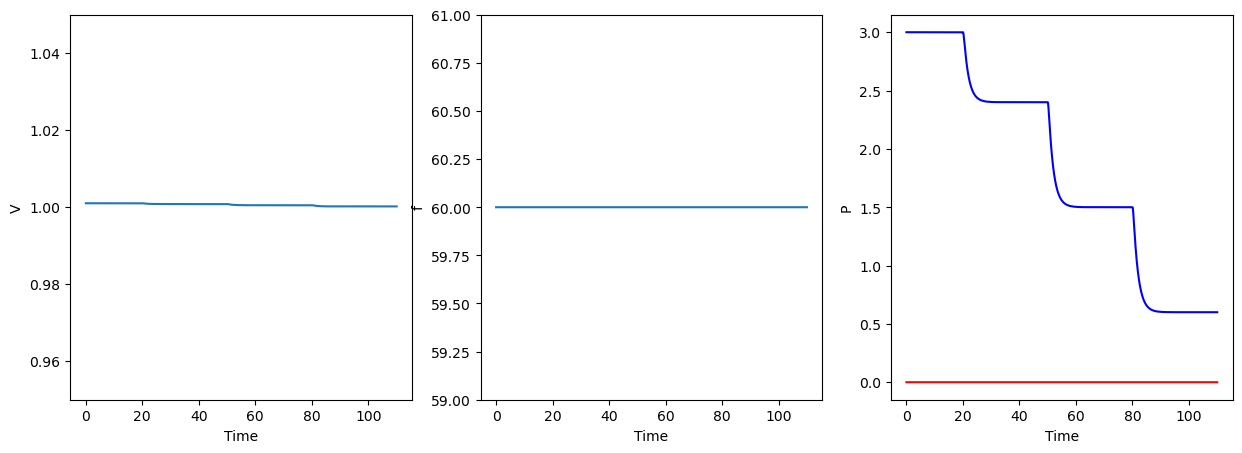

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(x = "Time", y = "V", data=df_A3, ax=ax[0])
ax[0].set_ylim([0.95, 1.05])
sns.lineplot(x = "Time", y = "f", data=df_A3, ax=ax[1])
ax[1].set_ylim([59, 61])
sns.lineplot(x = "Time", y = "P", data=df_A3, ax=ax[2], color='b')
sns.lineplot(x = "Time", y = "Q", data=df_A3, ax=ax[2], color='r')

In [19]:
df_A5_1 = sim_sim(5, 1)
df_A5_2 = sim_sim(5, 2)
df_A5_3 = sim_sim(5, 3)
df_A5_4 = sim_sim(5, 4)


 4 diagonal and 3 off-diagonal elements

     PTI INTERACTIVE POWER SYSTEM SIMULATOR--PSS(R)E     TUE, OCT 01 2024  15:04



 INITIAL CONDITION LOAD FLOW USED 1 ITERATIONS

 ----------------------------- MACHINE INITIAL CONDITIONS -----------------------------
   BUS#-SCT X-- NAME --X BASKV ID  ETERM   EFD    POWER    VARS   P.F.  ANGLE   ID     IQ
      1     GSULV       22.900 1  1.0010 0.0000    3.00    0.00 1.0000   0.39 0.0000 0.9990
      4     GRID        154.00 1  1.0004 1.0005   -2.95    0.80-0.9652  -0.02 0.0080-0.0295

 INITIAL CONDITIONS CHECK O.K.

 Channel output file is "C:/Users/smartgrid_AI/Desktop/netzero/case/a5c1.out"

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+1) [VAR(24) changed from 0.0 to 0.0

 RENEWABLE ELECTRICAL Model "REECA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+2) [VAR(13) changed from 0.0 to 0.0

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+3) [

<AxesSubplot: xlabel='Time', ylabel='P'>

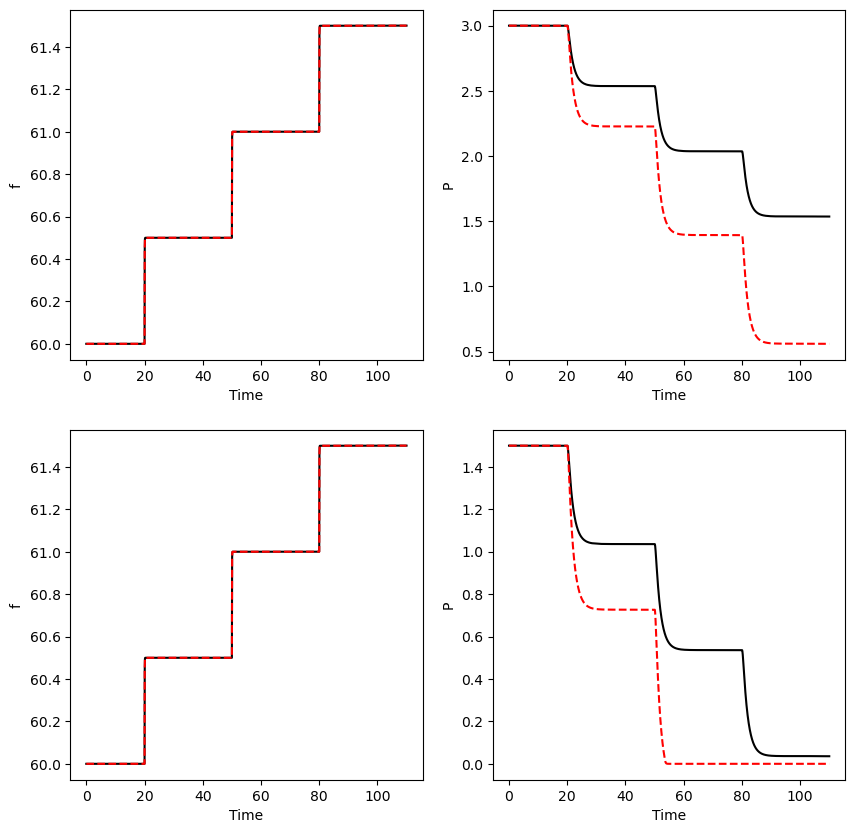

In [22]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
sns.lineplot(x = "Time", y = "f", data=df_A5_1, ax=ax[0, 0], color='k')
sns.lineplot(x = "Time", y = "f", data=df_A5_3, ax=ax[0, 0], linestyle='--', color='r')
sns.lineplot(x = "Time", y = "P", data=df_A5_1, ax=ax[0, 1], color='k')
sns.lineplot(x = "Time", y = "P", data=df_A5_3, ax=ax[0, 1], linestyle='--', color='r')
sns.lineplot(x = "Time", y = "f", data=df_A5_2, ax=ax[1, 0], color='k')
sns.lineplot(x = "Time", y = "f", data=df_A5_4, ax=ax[1, 0], linestyle='--', color='r')
sns.lineplot(x = "Time", y = "P", data=df_A5_2, ax=ax[1, 1], color='k')
sns.lineplot(x = "Time", y = "P", data=df_A5_4, ax=ax[1, 1], linestyle='--', color='r')

In [27]:
df_A6_1 = sim_sim(6, 1)
df_A6_2 = sim_sim(6, 2)


 4 diagonal and 3 off-diagonal elements

     PTI INTERACTIVE POWER SYSTEM SIMULATOR--PSS(R)E     TUE, OCT 01 2024  15:09



 INITIAL CONDITION LOAD FLOW USED 1 ITERATIONS

 ----------------------------- MACHINE INITIAL CONDITIONS -----------------------------
   BUS#-SCT X-- NAME --X BASKV ID  ETERM   EFD    POWER    VARS   P.F.  ANGLE   ID     IQ
      1     GSULV       22.900 1  1.0010 0.0000    3.00    0.00 1.0000   0.39 0.0000 0.9990
      4     GRID        154.00 1  1.0004 1.0005   -2.95    0.80-0.9652  -0.02 0.0080-0.0295

 INITIAL CONDITIONS CHECK O.K.

 Channel output file is "C:/Users/smartgrid_AI/Desktop/netzero/case/a6c1.out"

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+1) [VAR(18) changed from 0.0 to 0.0

 RENEWABLE ELECTRICAL Model "REECA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+2) [VAR(7) changed from 0.0 to 0.0

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+3) [V

<AxesSubplot: xlabel='Time', ylabel='P'>

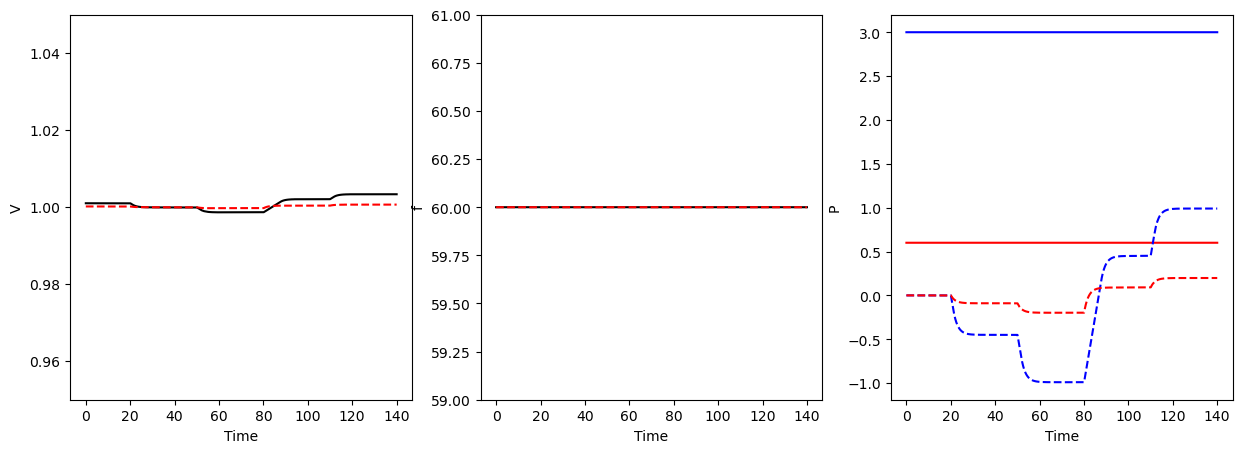

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(x = "Time", y = "V", data=df_A6_1, ax=ax[0], color='k')
sns.lineplot(x = "Time", y = "V", data=df_A6_2, ax=ax[0], linestyle='--',color='r')
ax[0].set_ylim([0.95, 1.05])
sns.lineplot(x = "Time", y = "f", data=df_A6_1, ax=ax[1], color='k')
sns.lineplot(x = "Time", y = "f", data=df_A6_2, ax=ax[1], linestyle='--',color='r')
ax[1].set_ylim([59, 61])
sns.lineplot(x = "Time", y = "P", data=df_A6_1, ax=ax[2], color='b')
sns.lineplot(x = "Time", y = "P", data=df_A6_2, ax=ax[2], color='r')
sns.lineplot(x = "Time", y = "Q", data=df_A6_1, ax=ax[2], linestyle='--',color='b')
sns.lineplot(x = "Time", y = "Q", data=df_A6_2, ax=ax[2], linestyle='--',color='r')

In [29]:
df_A7_1 = sim_sim(7, 1)
df_A7_2 = sim_sim(7, 2)


 4 diagonal and 3 off-diagonal elements

     PTI INTERACTIVE POWER SYSTEM SIMULATOR--PSS(R)E     TUE, OCT 01 2024  15:11



 INITIAL CONDITION LOAD FLOW USED 1 ITERATIONS

 ----------------------------- MACHINE INITIAL CONDITIONS -----------------------------
   BUS#-SCT X-- NAME --X BASKV ID  ETERM   EFD    POWER    VARS   P.F.  ANGLE   ID     IQ
      1     GSULV       22.900 1  1.0010 0.0000    3.00    0.00 1.0000   0.39 0.0000 0.9990
      4     GRID        154.00 1  1.0004 1.0005   -2.95    0.80-0.9652  -0.02 0.0080-0.0295

 INITIAL CONDITIONS CHECK O.K.

 Channel output file is "C:/Users/smartgrid_AI/Desktop/netzero/case/a7c1.out"

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+1) [VAR(18) changed from 0.0 to 0.0

 RENEWABLE ELECTRICAL Model "REECA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+2) [VAR(7) changed from 0.0 to 0.0

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+3) [V

<AxesSubplot: xlabel='Time', ylabel='P'>

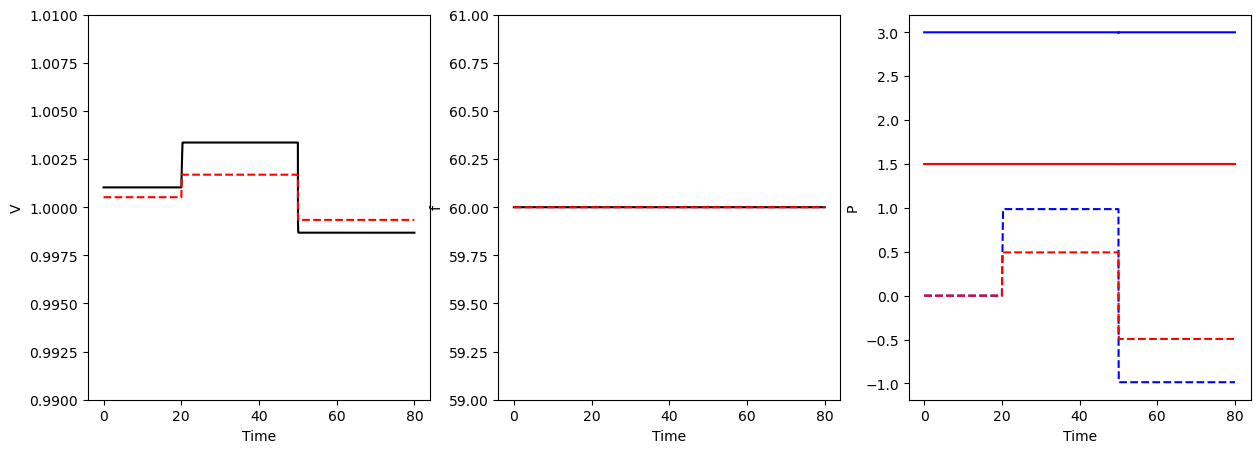

In [30]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(x = "Time", y = "V", data=df_A7_1, ax=ax[0], color='k')
sns.lineplot(x = "Time", y = "V", data=df_A7_2, ax=ax[0], linestyle='--',color='r')
ax[0].set_ylim([0.99, 1.01])
sns.lineplot(x = "Time", y = "f", data=df_A7_1, ax=ax[1], color='k')
sns.lineplot(x = "Time", y = "f", data=df_A7_2, ax=ax[1], linestyle='--',color='r')
ax[1].set_ylim([59, 61])
sns.lineplot(x = "Time", y = "P", data=df_A7_1, ax=ax[2], color='b')
sns.lineplot(x = "Time", y = "P", data=df_A7_2, ax=ax[2], color='r')
sns.lineplot(x = "Time", y = "Q", data=df_A7_1, ax=ax[2], linestyle='--',color='b')
sns.lineplot(x = "Time", y = "Q", data=df_A7_2, ax=ax[2], linestyle='--',color='r')

In [10]:
df_A8_1 = sim_sim(8, 1)
df_A8_2 = sim_sim(8, 2)


 4 diagonal and 3 off-diagonal elements

     PTI INTERACTIVE POWER SYSTEM SIMULATOR--PSS(R)E     TUE, OCT 01 2024  16:07



 INITIAL CONDITION LOAD FLOW USED 1 ITERATIONS

 ----------------------------- MACHINE INITIAL CONDITIONS -----------------------------
   BUS#-SCT X-- NAME --X BASKV ID  ETERM   EFD    POWER    VARS   P.F.  ANGLE   ID     IQ
      1     GSULV       22.900 1  1.0010 0.0000    3.00    0.00 1.0000   0.39 0.0000 0.9990
      4     GRID        154.00 1  1.0004 1.0005   -2.95    0.80-0.9652  -0.02 0.0080-0.0295

 INITIAL CONDITIONS CHECK O.K.

 Channel output file is "C:/Users/smartgrid_AI/Desktop/netzero/case/a8c1.out"

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+1) [VAR(24) changed from 0.0 to 0.0

 RENEWABLE ELECTRICAL Model "REECA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+2) [VAR(13) changed from 0.0 to 0.0

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+3) [

<AxesSubplot: xlabel='Time', ylabel='P'>

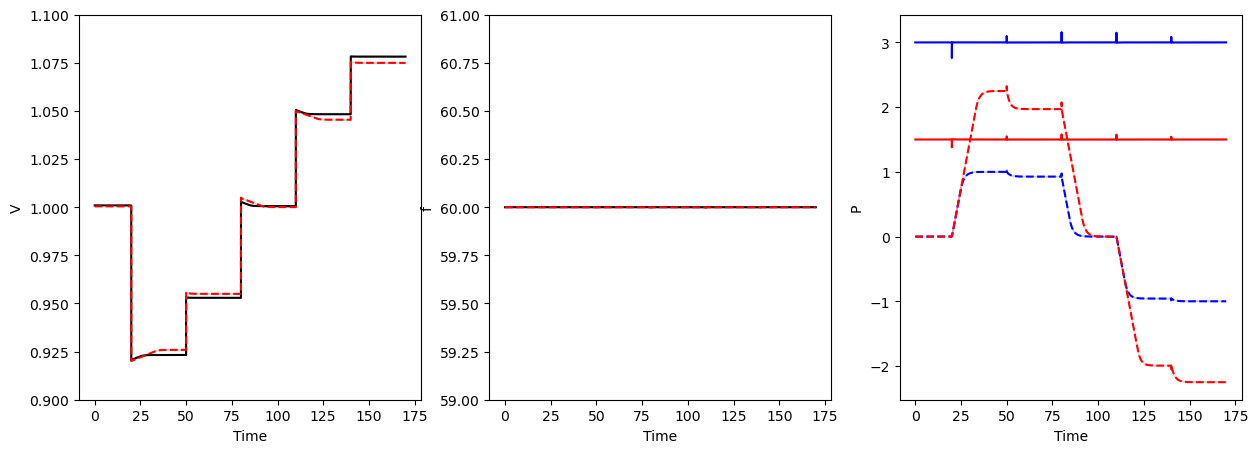

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(x = "Time", y = "V", data=df_A8_1, ax=ax[0], color='k')
sns.lineplot(x = "Time", y = "V", data=df_A8_2, ax=ax[0], linestyle='--',color='r')
ax[0].set_ylim([0.9, 1.1])
sns.lineplot(x = "Time", y = "f", data=df_A8_1, ax=ax[1], color='k')
sns.lineplot(x = "Time", y = "f", data=df_A8_2, ax=ax[1], linestyle='--',color='r')
ax[1].set_ylim([59, 61])
sns.lineplot(x = "Time", y = "P", data=df_A8_1, ax=ax[2], color='b')
sns.lineplot(x = "Time", y = "P", data=df_A8_2, ax=ax[2], color='r')
sns.lineplot(x = "Time", y = "Q", data=df_A8_1, ax=ax[2], linestyle='--',color='b')
sns.lineplot(x = "Time", y = "Q", data=df_A8_2, ax=ax[2], linestyle='--',color='r')

In [8]:
df_A10 = sim_sim(10, 1)


 4 diagonal and 3 off-diagonal elements

     PTI INTERACTIVE POWER SYSTEM SIMULATOR--PSS(R)E     TUE, OCT 01 2024  15:58



 INITIAL CONDITION LOAD FLOW USED 1 ITERATIONS

 ----------------------------- MACHINE INITIAL CONDITIONS -----------------------------
   BUS#-SCT X-- NAME --X BASKV ID  ETERM   EFD    POWER    VARS   P.F.  ANGLE   ID     IQ
      1     GSULV       22.900 1  1.0010 0.0000    3.00    0.00 1.0000   0.39 0.0000 0.9990
      4     GRID        154.00 1  1.0004 1.0005   -2.95    0.80-0.9652  -0.02 0.0080-0.0295

 INITIAL CONDITIONS CHECK O.K.

 Channel output file is "C:/Users/smartgrid_AI/Desktop/netzero/case/a10_1c1.out"

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+1) [VAR(24) changed from 0.0 to 0.0

 RENEWABLE ELECTRICAL Model "REECA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+2) [VAR(13) changed from 0.0 to 0.0

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+3

(0.95, 1.05)

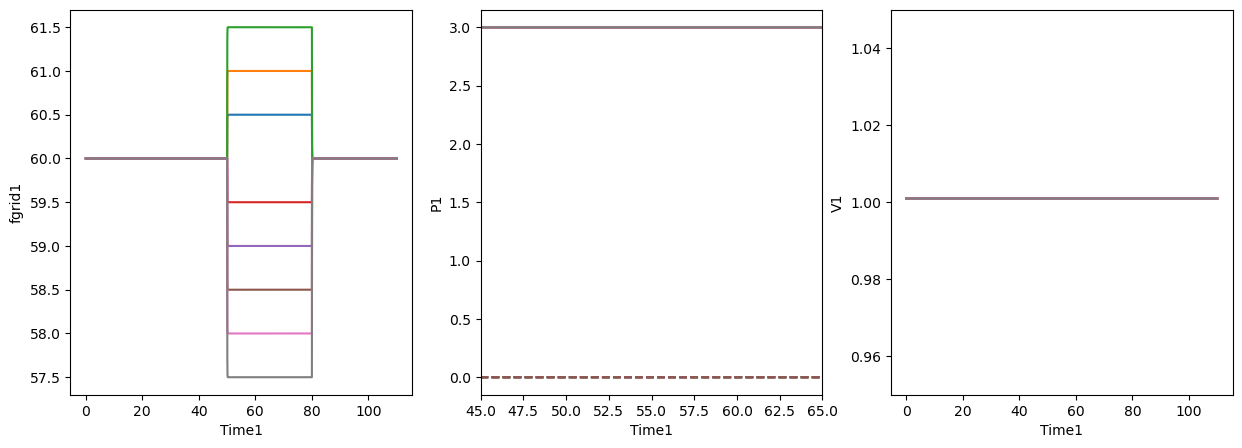

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(x = "Time1", y = "fgrid1", data=df_A10, ax=ax[0])
sns.lineplot(x = "Time1", y = "fgrid2", data=df_A10, ax=ax[0])
sns.lineplot(x = "Time1", y = "fgrid3", data=df_A10, ax=ax[0])
sns.lineplot(x = "Time1", y = "fgrid4", data=df_A10, ax=ax[0])
sns.lineplot(x = "Time1", y = "fgrid5", data=df_A10, ax=ax[0])
sns.lineplot(x = "Time1", y = "fgrid6", data=df_A10, ax=ax[0])
sns.lineplot(x = "Time1", y = "fgrid7", data=df_A10, ax=ax[0])
sns.lineplot(x = "Time1", y = "fgrid8", data=df_A10, ax=ax[0])

sns.lineplot(x = "Time1", y = "P1", data=df_A10, ax=ax[1])
sns.lineplot(x = "Time1", y = "P2", data=df_A10, ax=ax[1])
sns.lineplot(x = "Time1", y = "P3", data=df_A10, ax=ax[1])
sns.lineplot(x = "Time1", y = "P4", data=df_A10, ax=ax[1])
sns.lineplot(x = "Time1", y = "P5", data=df_A10, ax=ax[1])
sns.lineplot(x = "Time1", y = "P6", data=df_A10, ax=ax[1])
sns.lineplot(x = "Time1", y = "P7", data=df_A10, ax=ax[1])
sns.lineplot(x = "Time1", y = "P8", data=df_A10, ax=ax[1])
#ax[1].set_ylim([1, 5])
ax[1].set_xlim([45, 65])

sns.lineplot(x = "Time1", y = "Q1", data=df_A10, linestyle='--', ax=ax[1])
sns.lineplot(x = "Time1", y = "Q2", data=df_A10, linestyle='--', ax=ax[1])
sns.lineplot(x = "Time1", y = "Q3", data=df_A10, linestyle='--', ax=ax[1])
sns.lineplot(x = "Time1", y = "Q4", data=df_A10, linestyle='--', ax=ax[1])
sns.lineplot(x = "Time1", y = "Q5", data=df_A10, linestyle='--', ax=ax[1])
sns.lineplot(x = "Time1", y = "Q6", data=df_A10, linestyle='--', ax=ax[1])
sns.lineplot(x = "Time1", y = "Q7", data=df_A10, linestyle='--', ax=ax[1])
sns.lineplot(x = "Time1", y = "Q8", data=df_A10, linestyle='--', ax=ax[1])

sns.lineplot(x = "Time1", y = "V1", data=df_A10, ax=ax[2])
sns.lineplot(x = "Time1", y = "V2", data=df_A10, ax=ax[2])
sns.lineplot(x = "Time1", y = "V3", data=df_A10, ax=ax[2])
sns.lineplot(x = "Time1", y = "V4", data=df_A10, ax=ax[2])
sns.lineplot(x = "Time1", y = "V5", data=df_A10, ax=ax[2])
sns.lineplot(x = "Time1", y = "V6", data=df_A10, ax=ax[2])
sns.lineplot(x = "Time1", y = "V7", data=df_A10, ax=ax[2])
sns.lineplot(x = "Time1", y = "V8", data=df_A10, ax=ax[2])
ax[2].set_ylim([0.95, 1.05])

In [10]:
df_A11_1 = sim_sim(11, 1)


 4 diagonal and 3 off-diagonal elements

     PTI INTERACTIVE POWER SYSTEM SIMULATOR--PSS(R)E     TUE, OCT 01 2024  15:59



 INITIAL CONDITION LOAD FLOW USED 1 ITERATIONS

 ----------------------------- MACHINE INITIAL CONDITIONS -----------------------------
   BUS#-SCT X-- NAME --X BASKV ID  ETERM   EFD    POWER    VARS   P.F.  ANGLE   ID     IQ
      1     GSULV       22.900 1  1.0010 0.0000    3.00    0.00 1.0000   0.39 0.0000 0.9990
      4     GRID        154.00 1  1.0004 1.0005   -2.95    0.80-0.9652  -0.02 0.0080-0.0295

 INITIAL CONDITIONS CHECK O.K.

 Channel output file is "C:/Users/smartgrid_AI/Desktop/netzero/case/a11_1c1.out"

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+1) [VAR(24) changed from 0.0 to 0.0

 RENEWABLE ELECTRICAL Model "REECA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+2) [VAR(13) changed from 0.0 to 0.0

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+3

(49.0, 55.0)

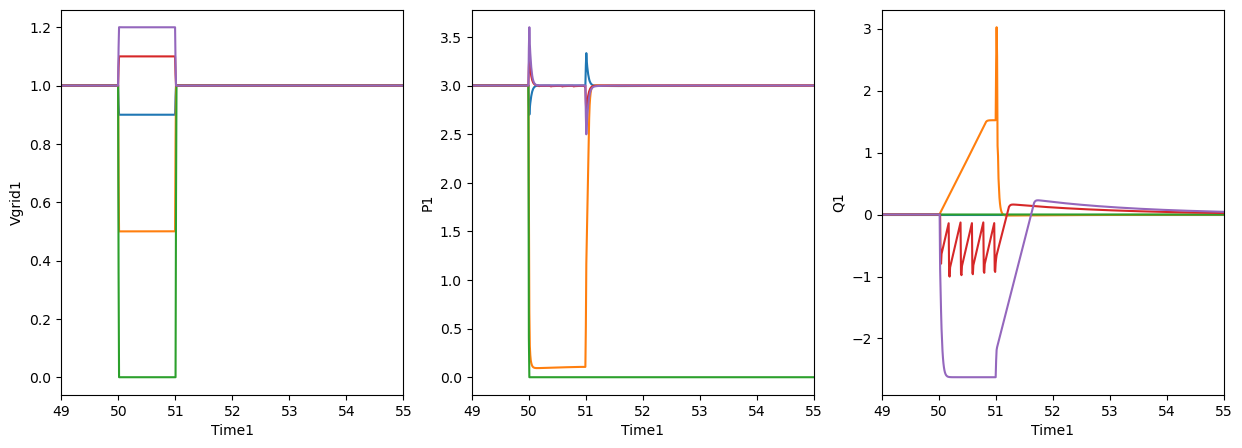

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(x = "Time1", y = "Vgrid1", data=df_A11_1, ax=ax[0])
sns.lineplot(x = "Time1", y = "Vgrid2", data=df_A11_1, ax=ax[0])
sns.lineplot(x = "Time1", y = "Vgrid3", data=df_A11_1, ax=ax[0])
sns.lineplot(x = "Time1", y = "Vgrid4", data=df_A11_1, ax=ax[0])
sns.lineplot(x = "Time1", y = "Vgrid5", data=df_A11_1, ax=ax[0])
ax[0].set_xlim([49, 55])

sns.lineplot(x = "Time1", y = "P1", data=df_A11_1, ax=ax[1])
sns.lineplot(x = "Time1", y = "P2", data=df_A11_1, ax=ax[1])
sns.lineplot(x = "Time1", y = "P3", data=df_A11_1, ax=ax[1])
sns.lineplot(x = "Time1", y = "P4", data=df_A11_1, ax=ax[1])
sns.lineplot(x = "Time1", y = "P5", data=df_A11_1, ax=ax[1])
ax[1].set_xlim([49, 55])
#ax[1].set_ylim([0, 5])
sns.lineplot(x = "Time1", y = "Q1", data=df_A11_1, ax=ax[2])
sns.lineplot(x = "Time1", y = "Q2", data=df_A11_1, ax=ax[2])
sns.lineplot(x = "Time1", y = "Q3", data=df_A11_1, ax=ax[2])
sns.lineplot(x = "Time1", y = "Q4", data=df_A11_1, ax=ax[2])
sns.lineplot(x = "Time1", y = "Q5", data=df_A11_1, ax=ax[2])
ax[2].set_xlim([49, 55])
#ax[2].set_ylim([-5, 5])

In [8]:
df_A11_2 = sim_sim(11, 2)


 4 diagonal and 3 off-diagonal elements

     PTI INTERACTIVE POWER SYSTEM SIMULATOR--PSS(R)E     TUE, OCT 01 2024  16:03



 INITIAL CONDITION LOAD FLOW USED 1 ITERATIONS

 ----------------------------- MACHINE INITIAL CONDITIONS -----------------------------
   BUS#-SCT X-- NAME --X BASKV ID  ETERM   EFD    POWER    VARS   P.F.  ANGLE   ID     IQ
      1     GSULV       22.900 1  1.0002 0.0000    0.60    0.00 1.0000   0.08 0.0000 0.2000
      4     GRID        154.00 1  1.0004 1.0005   -0.56    0.78-0.5814  -0.00 0.0078-0.0056

 INITIAL CONDITIONS CHECK O.K.

 Channel output file is "C:/Users/smartgrid_AI/Desktop/netzero/case/a11_1c2.out"

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+1) [VAR(24) changed from -0.0 to 0.0

 RENEWABLE ELECTRICAL Model "REECA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+2) [VAR(13) changed from 0.0 to 0.0

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+

(49.0, 55.0)

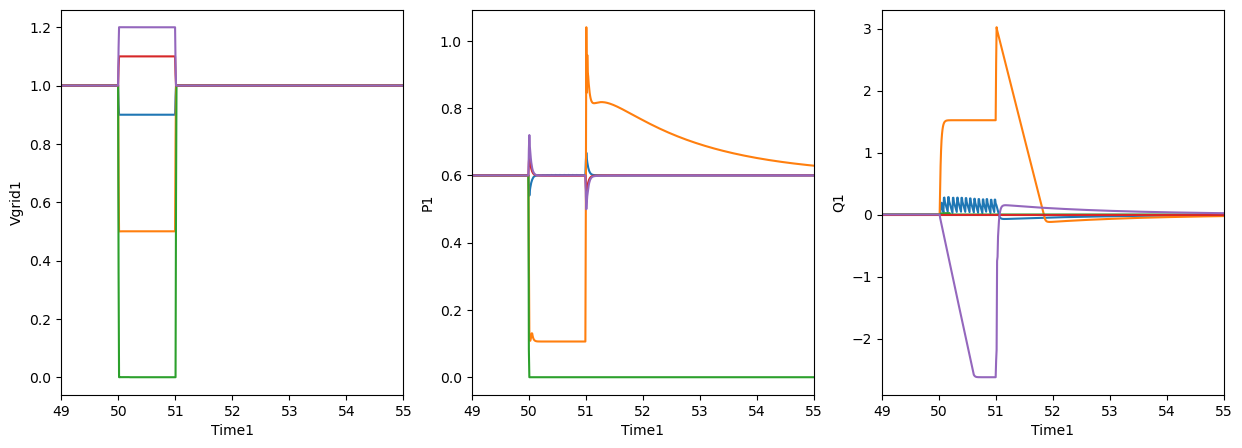

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(x = "Time1", y = "Vgrid1", data=df_A11_2, ax=ax[0])
sns.lineplot(x = "Time1", y = "Vgrid2", data=df_A11_2, ax=ax[0])
sns.lineplot(x = "Time1", y = "Vgrid3", data=df_A11_2, ax=ax[0])
sns.lineplot(x = "Time1", y = "Vgrid4", data=df_A11_2, ax=ax[0])
sns.lineplot(x = "Time1", y = "Vgrid5", data=df_A11_2, ax=ax[0])
ax[0].set_xlim([49, 55])

sns.lineplot(x = "Time1", y = "P1", data=df_A11_2, ax=ax[1])
sns.lineplot(x = "Time1", y = "P2", data=df_A11_2, ax=ax[1])
sns.lineplot(x = "Time1", y = "P3", data=df_A11_2, ax=ax[1])
sns.lineplot(x = "Time1", y = "P4", data=df_A11_2, ax=ax[1])
sns.lineplot(x = "Time1", y = "P5", data=df_A11_2, ax=ax[1])
ax[1].set_xlim([49, 55])
#ax[1].set_ylim([0, 5])
sns.lineplot(x = "Time1", y = "Q1", data=df_A11_2, ax=ax[2])
sns.lineplot(x = "Time1", y = "Q2", data=df_A11_2, ax=ax[2])
sns.lineplot(x = "Time1", y = "Q3", data=df_A11_2, ax=ax[2])
sns.lineplot(x = "Time1", y = "Q4", data=df_A11_2, ax=ax[2])
sns.lineplot(x = "Time1", y = "Q5", data=df_A11_2, ax=ax[2])
ax[2].set_xlim([49, 55])
#ax[2].set_ylim([-5, 5])

In [14]:
df_A12_1 = sim_sim(12, 1)


 4 diagonal and 3 off-diagonal elements

     PTI INTERACTIVE POWER SYSTEM SIMULATOR--PSS(R)E     TUE, OCT 01 2024  16:02



 INITIAL CONDITION LOAD FLOW USED 1 ITERATIONS

 ----------------------------- MACHINE INITIAL CONDITIONS -----------------------------
   BUS#-SCT X-- NAME --X BASKV ID  ETERM   EFD    POWER    VARS   P.F.  ANGLE   ID     IQ
      1     GSULV       22.900 1  1.0010 0.0000    3.00    0.00 1.0000   0.39 0.0000 0.9990
      4     GRID        154.00 1  1.0004 1.0005   -2.95    0.80-0.9652  -0.02 0.0080-0.0295

 INITIAL CONDITIONS CHECK O.K.

 Channel output file is "C:/Users/smartgrid_AI/Desktop/netzero/case/a12_1c1.out"

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+1) [VAR(24) changed from 0.0 to 0.0

 RENEWABLE ELECTRICAL Model "REECA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+2) [VAR(13) changed from 0.0 to 0.0

 RENEWABLE AUXILIARY Model "REPCA1" at bus 1     [GSULV       22.900] machine "1":
  VAR(J+3

<AxesSubplot: xlabel='Time1', ylabel='Q1'>

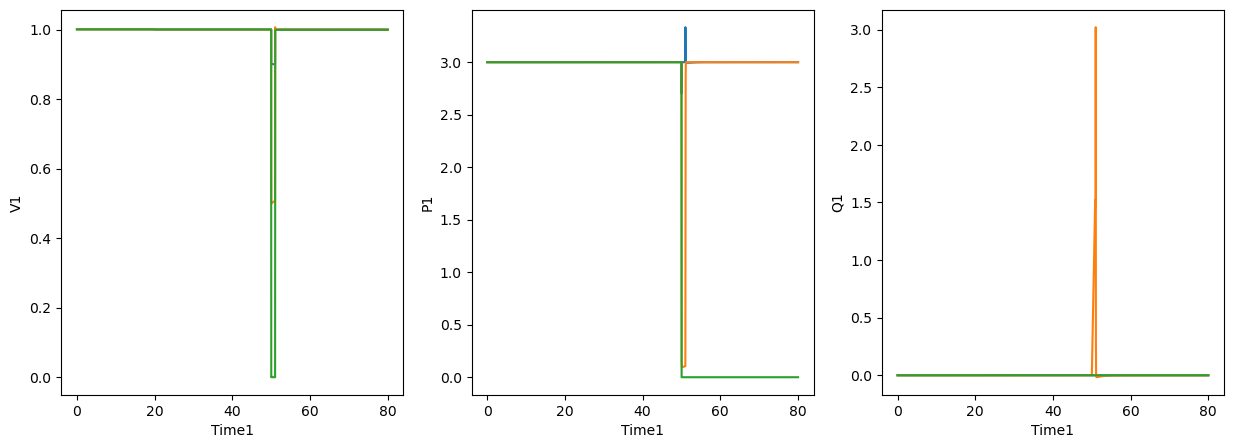

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(x = "Time1", y = "V1", data=df_A12_1, ax=ax[0])
sns.lineplot(x = "Time1", y = "V2", data=df_A12_1, ax=ax[0])
sns.lineplot(x = "Time1", y = "V3", data=df_A12_1, ax=ax[0])

sns.lineplot(x = "Time1", y = "P1", data=df_A12_1, ax=ax[1])
sns.lineplot(x = "Time1", y = "P2", data=df_A12_1, ax=ax[1])
sns.lineplot(x = "Time1", y = "P3", data=df_A12_1, ax=ax[1])

sns.lineplot(x = "Time1", y = "Q1", data=df_A12_1, ax=ax[2])
sns.lineplot(x = "Time1", y = "Q2", data=df_A12_1, ax=ax[2])
sns.lineplot(x = "Time1", y = "Q3", data=df_A12_1, ax=ax[2])